# Project 9 - Data Engineering
Γεώργιος Δάλλας
ΑΕΜ: 217


In [1]:
import pandas as pd 
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.datasets import mnist 
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import umap

## 1.
Since there are a lot of features in the bankloan.csv dataset, ydata_profiling is used to create a report (description) html file, containing the data type of each feature, the correlations, missing data, distributions , imbalances etc. 

In [2]:
df = pd.read_csv("bankloan.csv")
#profile = ProfileReport(df, title="Pandas Profiling Report")
#profile.to_file("report.html")

## 2.
### 1)
By selecting the loant_amnt variable in the report.html, it is clearly visible that the minimum amount that people ask for a loan is 1000. The maximum amount is 35000 and the mean loan amount is 15257.96.
### 2)
Features to drop: <br/>
Unnamed: 50 = just a null collumn<br/>
member_id, id, Row ID = All 100% unique and contain no useful information regarding a lawn<br/>
36months , 60months = exact oposites and term feature contains the info if its 36 or 60 so we can just keep that<br/>
mths_since_last_major_derog, mths_since_last_delinq = drop we dont know null values if its 0 months and 70% / 48% is high<br/>


In [3]:
df = df.drop(['Unnamed: 50','member_id','id','Row ID','36months','60months','mths_since_last_major_derog','mths_since_last_delinq'],axis=1)


### 3) Preprocessing:
Handling null values:<br/>
annual_inc_joint, dti_joint = make nulls zero <br/>
emp_title = make nulls """ <br/>
emp_length = make nulls """ <br/>
last_pymnt_d = make nulls """<br/>
next_pymnt_d = make nulls """<br/>
annual_inc_joint = where null put annual_inc<br/>
dti_joint = where null put dti<br/>


In [4]:
df['annual_inc_joint'] = df['annual_inc_joint'].fillna(0)
df['dti_joint'] = df['dti_joint'].fillna(0)
for col in ['emp_title', 'emp_length', 'last_pymnt_d', 'next_pymnt_d']:
    df[col] = df[col].fillna("")

df['annual_inc_joint'] = df['annual_inc_joint'].fillna(df['annual_inc'])
df['dti_joint'] = df['dti_joint'].fillna(df['dti'])


tunring categorical into numerical using label encoding

In [5]:

categorical_cols = ["term", "grade","sub_grade","emp_title","emp_length","home_ownership","verification_status","issue_d","loan_status","purpose","title","earliest_cr_line","initial_list_status","last_pymnt_d","next_pymnt_d","last_credit_pull_d","application_type"]
for i in categorical_cols:
    df[i] = df[i].astype("category")
    mapping = dict(enumerate(df[i].cat.categories))
   # print("Conversion for", i)
    #print(mapping)
   # print()
    df[i] = df[i].cat.codes #make them numerical


### 4) 
Α, Β1, Β2 are the ones that get the lawn. So target = 1. <br/>
Since subgrade contains all the information about grade, and these will get transfered to target, we can drop them after creating the target.


In [6]:
maskGrade = df['sub_grade'] <=7
df['target'] = 0 
df.loc[maskGrade, 'target'] = 1
df = df.drop(['grade','sub_grade'],axis=1)


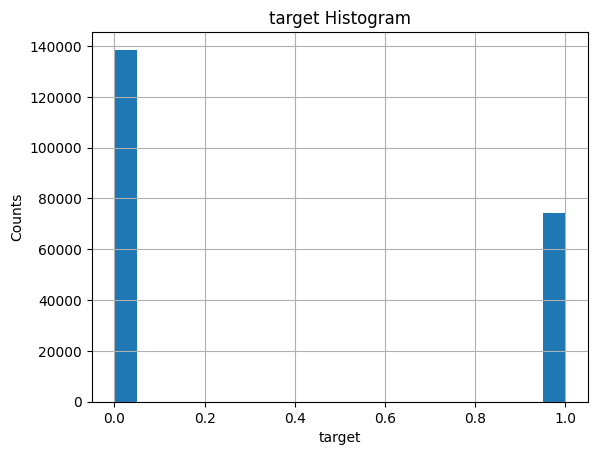

In [7]:
df['target'].hist(bins=20)
plt.title('target Histogram')
plt.xlabel('target')
plt.ylabel('Counts')
plt.show()

### 5)
The most probable range to get their lawn request accepted is 5000-10000

In [8]:
vals = [0, 5000, 10000, 15000, 20000, 25000, 30000, 35000]

for i in range(len(vals)-1):

    mask = (df['loan_amnt'] >= vals[i]) & (df['loan_amnt'] < vals[i+1])
    approval_prob = df.loc[mask, 'target'].mean()
    total = mask.sum()
    print('for range:',vals[i],"-",vals[i+1],"probability of acceptance:",approval_prob)


for range: 0 - 5000 probability of acceptance: 0.25294366282229336
for range: 5000 - 10000 probability of acceptance: 0.42037573227392094
for range: 10000 - 15000 probability of acceptance: 0.356653572063091
for range: 15000 - 20000 probability of acceptance: 0.3482354236634917
for range: 20000 - 25000 probability of acceptance: 0.34557934302990684
for range: 25000 - 30000 probability of acceptance: 0.4094373174139464
for range: 30000 - 35000 probability of acceptance: 0.21904096834264433


## 3. Classification
### 1) 
For normalization i used StandardScaler (z-score) since many features have different ranges 

In [9]:

input_df = df.drop(columns=['target'])
targets_df = df['target']
x = input_df.to_numpy()
y = targets_df.to_numpy().astype(int)
scaler = StandardScaler()
x_norm = scaler.fit_transform(x)


### 2)
The dataset is split 70%/30% train/test subsets.<br/>
Statify is used to keep the 1/0 distribution of y into the subsets

In [10]:
seed = 42
test_size = 0.3
x_train, x_test, y_train, y_test = train_test_split(x_norm, y, test_size=test_size, random_state=seed, stratify=y)



### 3)
Decision Tree was used with cross validation to determine the best depth of the tree. It was the classifier of preference since explainability must be an important factor in determining the acceptance of a loan.

Best max_depth: {'max_depth': 8}
Best f1: 0.9999616225965303


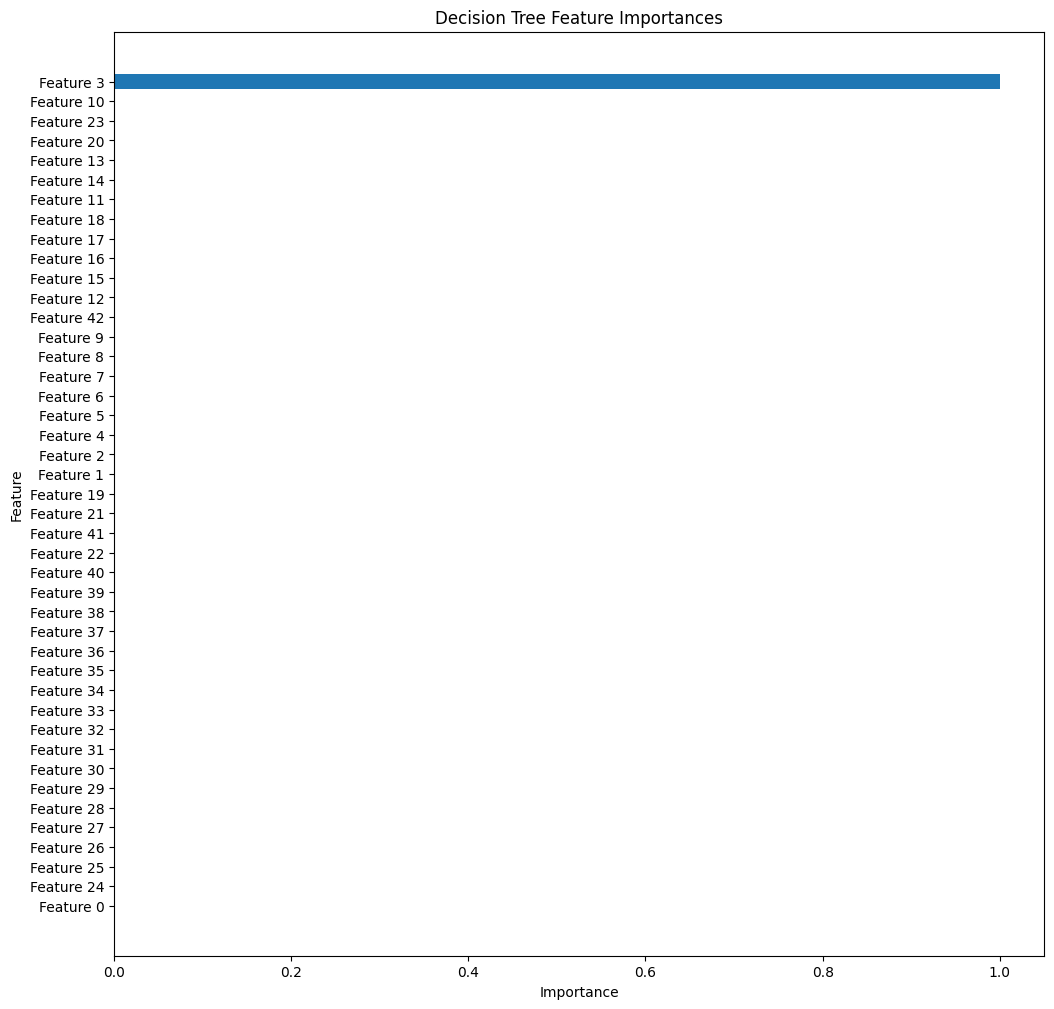

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212999 entries, 0 to 212998
Data columns (total 44 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   loan_amnt                   212999 non-null  int64  
 1   funded_amnt                 212999 non-null  int64  
 2   term                        212999 non-null  int8   
 3   int_rate                    212999 non-null  float64
 4   installment                 212999 non-null  float64
 5   emp_title                   212999 non-null  int32  
 6   emp_length                  212999 non-null  int8   
 7   home_ownership              212999 non-null  int8   
 8   annual_inc                  212999 non-null  float64
 9   verification_status         212999 non-null  int8   
 10  issue_d                     212999 non-null  int8   
 11  loan_status                 212999 non-null  int8   
 12  purpose                     212999 non-null  int8   
 13  title         

In [11]:
parameters = {'max_depth': [2,4,6,8,10,12,20,30,40,50,60,100]}
tr = DecisionTreeClassifier(random_state=seed)
cv= GridSearchCV(tr, parameters, cv=4, scoring='f1',n_jobs=-1)
cv.fit(x_train, y_train)
print("Best max_depth:", cv.best_params_)
print("Best f1:", cv.best_score_)
tr = DecisionTreeClassifier(random_state=seed,max_depth=8)
tr.fit(x_train,y_train)

importances = tr.feature_importances_

feature_names = [f'Feature {i}' for i in range(len(importances))]
indices = np.argsort(importances)

plt.figure(figsize=(12,12))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Decision Tree Feature Importances')
plt.show()
df.info()

int_rate,total_rec_prncp, total_rec_int and  total_rec_late_fee are information leakage features. That make sense since bank gives high int_rate to unlikely candidates and low to likely to be accepted. Also principal and interest received give direct information about the loan, so we know they have a loan.
So they get removed. The results seem much more fair.

Best max_depth: {'max_depth': 20}
Best f1: 0.764741121396787


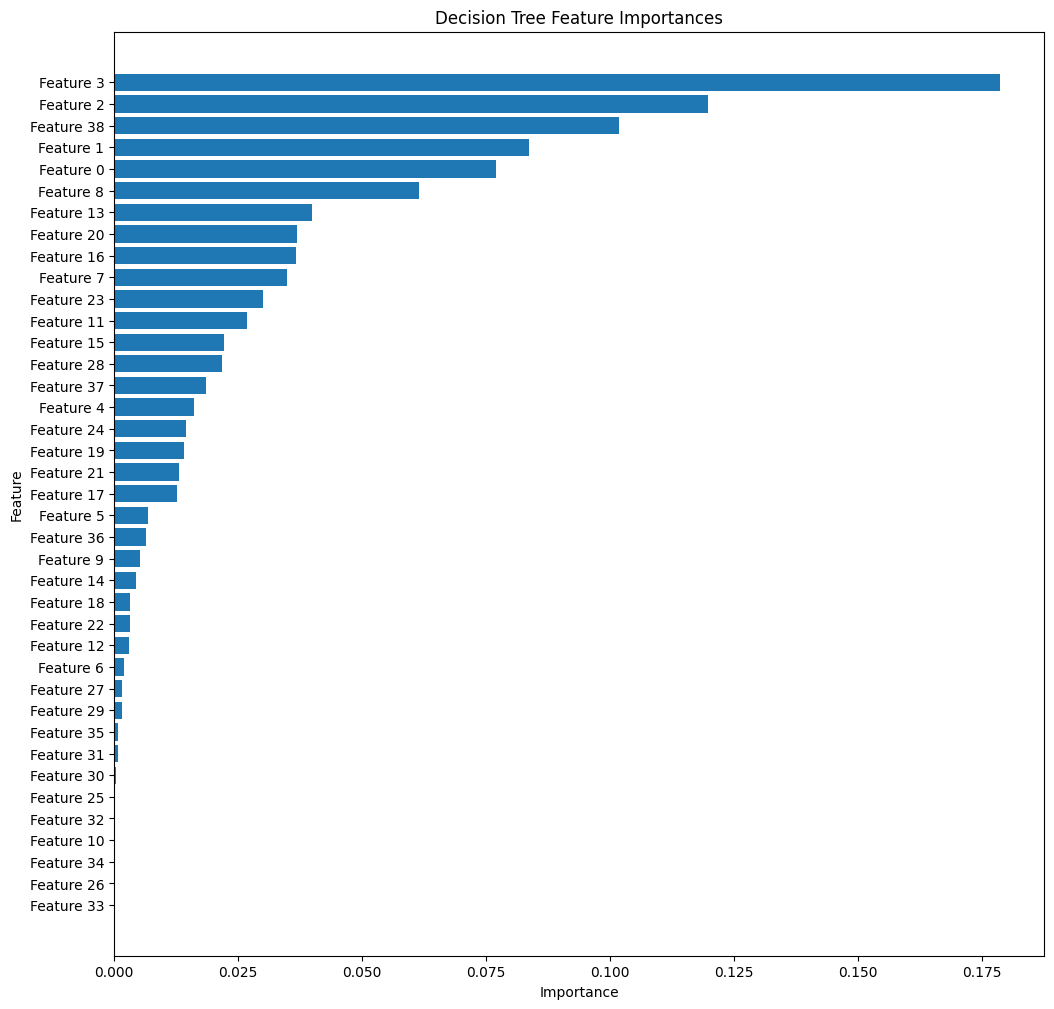

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212999 entries, 0 to 212998
Data columns (total 40 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   loan_amnt                   212999 non-null  int64  
 1   funded_amnt                 212999 non-null  int64  
 2   term                        212999 non-null  int8   
 3   installment                 212999 non-null  float64
 4   emp_title                   212999 non-null  int32  
 5   emp_length                  212999 non-null  int8   
 6   home_ownership              212999 non-null  int8   
 7   annual_inc                  212999 non-null  float64
 8   verification_status         212999 non-null  int8   
 9   issue_d                     212999 non-null  int8   
 10  loan_status                 212999 non-null  int8   
 11  purpose                     212999 non-null  int8   
 12  title                       212999 non-null  int8   
 13  dti           

In [12]:
df = df.drop(['int_rate','total_rec_prncp','total_rec_int','total_rec_late_fee'],axis=1)

input_df = df.drop(columns=['target'])
targets_df = df['target']
x = input_df.to_numpy()
y = targets_df.to_numpy().astype(int)
scaler = StandardScaler()
x_norm = scaler.fit_transform(x)
seed = 42
test_size = 0.3
x_train, x_test, y_train, y_test = train_test_split(x_norm, y, test_size=test_size, random_state=seed, stratify=y)

parameters = {'max_depth': [2,4,6,8,10,12,20,30,40,50,60,100]}
tr = DecisionTreeClassifier(random_state=seed)
cv= GridSearchCV(tr, parameters, cv=4, scoring='f1',n_jobs=-1)
cv.fit(x_train, y_train)
print("Best max_depth:", cv.best_params_)
print("Best f1:", cv.best_score_)
tr = DecisionTreeClassifier(max_depth=20, random_state=seed)
tr.fit(x_train,y_train)

importances = tr.feature_importances_

feature_names = [f'Feature {i}' for i in range(len(importances))]
indices = np.argsort(importances)

plt.figure(figsize=(12,12))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Decision Tree Feature Importances')
plt.show()
df.info()

### 4)
F1 is the most imporant metric since the classes are imbalanced and we care both for precision and recall

In [13]:
tr = DecisionTreeClassifier(max_depth=20, random_state=seed)
tr.fit(x_train,y_train)
y_pred = tr.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.8455086071987481
Precision: 0.770758201173148
Recall: 0.7942243116185359
F1-score: 0.7823153252480706


## 4. Feature Importance & Selection
### 1) A random forest classifier is used to find the 15 most important features.
They were: term,installement,total_rev_hi_lim,last_pymnt_amnt,revol_util,out_prncp,dti,funded_amnt,loan_amnt,annual_inc,verification_status,revol_bal,earliest_cr_line,tot_cur_bal,inq_last_6mths


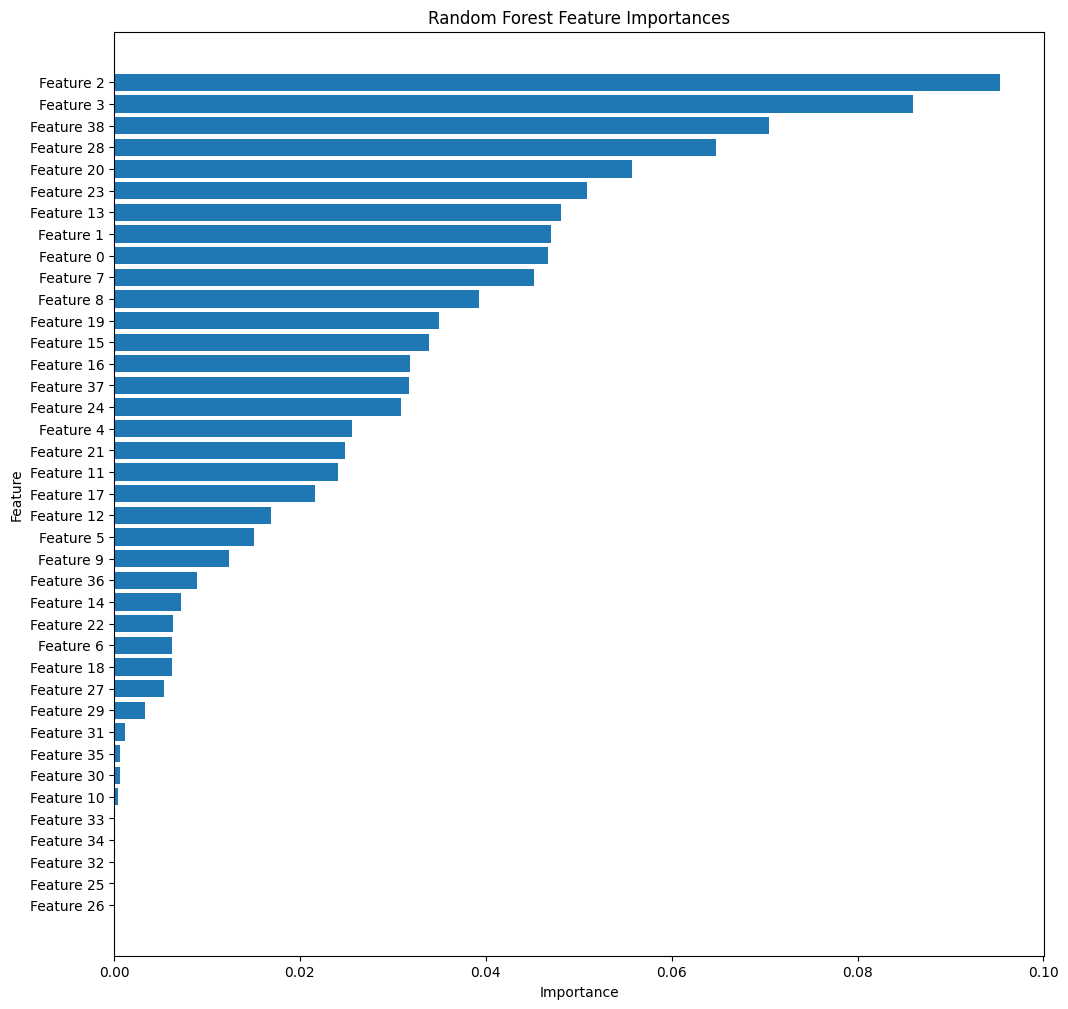

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212999 entries, 0 to 212998
Data columns (total 40 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   loan_amnt                   212999 non-null  int64  
 1   funded_amnt                 212999 non-null  int64  
 2   term                        212999 non-null  int8   
 3   installment                 212999 non-null  float64
 4   emp_title                   212999 non-null  int32  
 5   emp_length                  212999 non-null  int8   
 6   home_ownership              212999 non-null  int8   
 7   annual_inc                  212999 non-null  float64
 8   verification_status         212999 non-null  int8   
 9   issue_d                     212999 non-null  int8   
 10  loan_status                 212999 non-null  int8   
 11  purpose                     212999 non-null  int8   
 12  title                       212999 non-null  int8   
 13  dti           

In [14]:
rf = RandomForestClassifier()
rf.fit(x_train,y_train)

importances = rf.feature_importances_

feature_names = [f'Feature {i}' for i in range(len(importances))]
indices = np.argsort(importances)

plt.figure(figsize=(12,12))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importances')
plt.show()
df.info()

### 3) The correlation matrix of those features is printed.
out_prncp is highly correlated with installment and funded_amnt and loan_amnt, funded_amnt with installment and out_prncp, loan_amnt with installment and out_prncp, funded_amnt is ofc highly correlated with loan_amnt and finally revol_bal is correlated with total_rev_hi_lim

<Figure size 4000x4000 with 0 Axes>

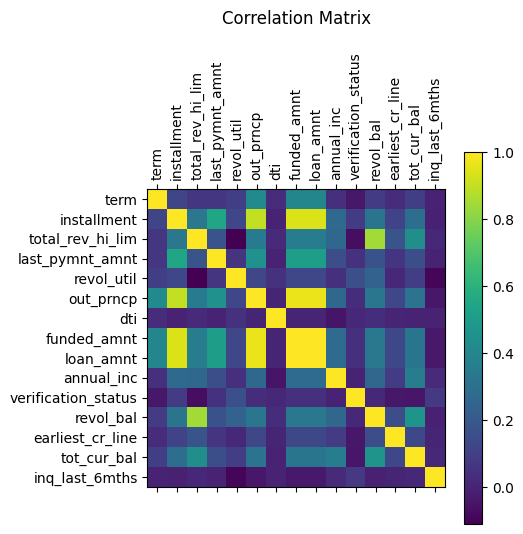

In [15]:
features_imp = [
    'term', 'installment', 'total_rev_hi_lim', 'last_pymnt_amnt', 
    'revol_util', 'out_prncp', 'dti', 'funded_amnt', 'loan_amnt', 
    'annual_inc', 'verification_status', 'revol_bal', 'earliest_cr_line', 
    'tot_cur_bal', 'inq_last_6mths'
]

df_with_only_important = df[features_imp].copy()
corr_matrix = df_with_only_important.corr()
plt.figure(figsize=(40, 40))
plt.matshow(corr_matrix.values)  
plt.colorbar()


plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)

plt.title('Correlation Matrix', pad=20)
plt.show()

### 4)
So we can drop funded_amnt, loan_amnt and out_prncp since they are all correlated to installement.

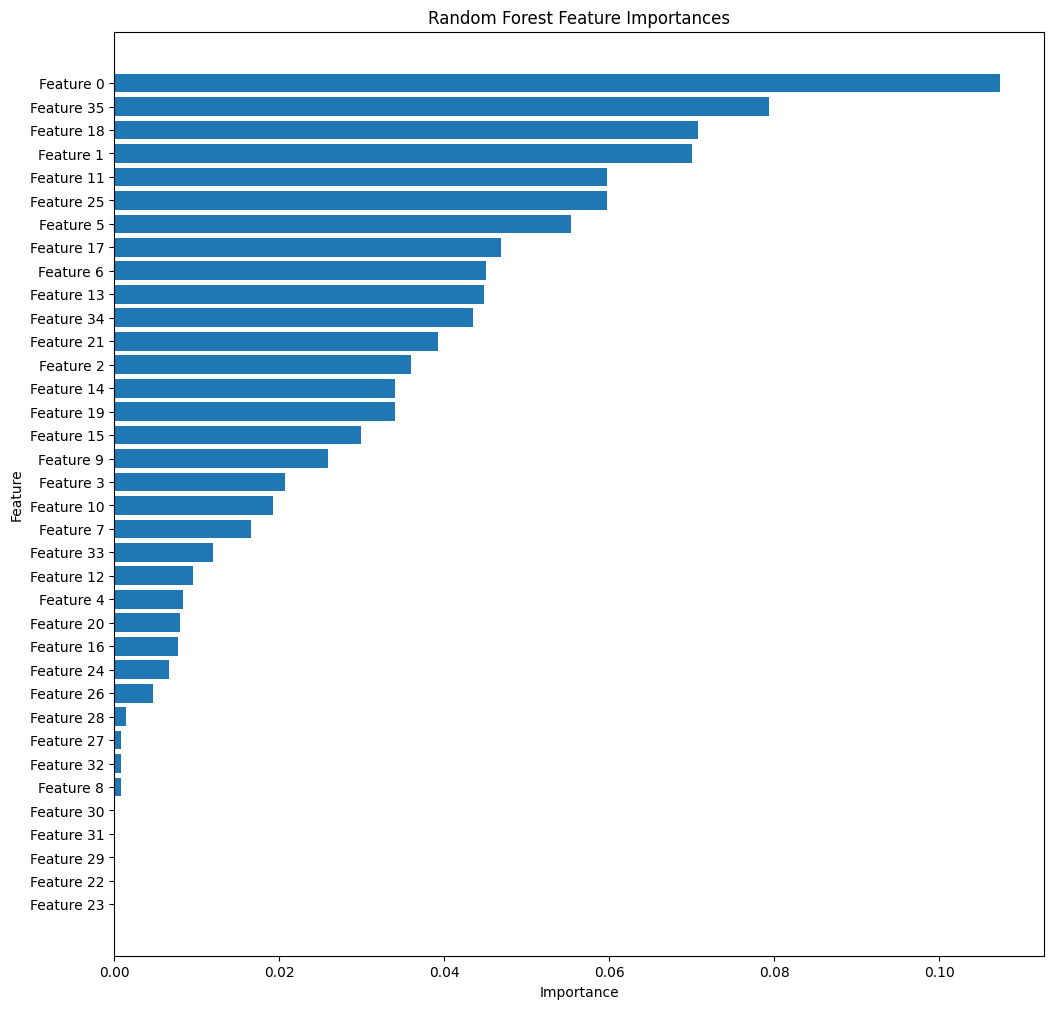

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212999 entries, 0 to 212998
Data columns (total 37 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   term                        212999 non-null  int8   
 1   installment                 212999 non-null  float64
 2   emp_title                   212999 non-null  int32  
 3   emp_length                  212999 non-null  int8   
 4   home_ownership              212999 non-null  int8   
 5   annual_inc                  212999 non-null  float64
 6   verification_status         212999 non-null  int8   
 7   issue_d                     212999 non-null  int8   
 8   loan_status                 212999 non-null  int8   
 9   purpose                     212999 non-null  int8   
 10  title                       212999 non-null  int8   
 11  dti                         212999 non-null  float64
 12  delinq_2yrs                 212999 non-null  int64  
 13  earliest_cr_li

In [16]:
df = df.drop(['funded_amnt','loan_amnt','out_prncp'],axis=1)

input_df = df.drop(columns=['target'])
targets_df = df['target']
x = input_df.to_numpy()
y = targets_df.to_numpy().astype(int)
scaler = StandardScaler()
x_norm = scaler.fit_transform(x)
seed = 42
test_size = 0.3
x_train, x_test, y_train, y_test = train_test_split(x_norm, y, test_size=test_size, random_state=seed, stratify=y)
rf = RandomForestClassifier()
rf.fit(x_train,y_train)

importances = rf.feature_importances_

feature_names = [f'Feature {i}' for i in range(len(importances))]
indices = np.argsort(importances)

plt.figure(figsize=(12,12))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importances')
plt.show()
df.info()


## 5. Dimensionality Reduction
### 1)
MNIST is loaded and flattened.

In [17]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print(x_train.shape)
print(x_test.shape)
x_train = x_train.reshape((60000, 28 * 28))
x_test = x_test.reshape((10000, 28 * 28))
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)
(60000, 784)
(10000, 784)


### 2)
they are then scaled.

In [18]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

### 3) 
PCA is used before using KNN.
If fit_transform is used in train and again in test, different eigenvectors will be created so there will be a missmatch when training and predicting in inputs.
If we use fit_trainform(train+test) then there will be information leakage in choosing the 300 first principal compoinent because we used x_test too to determine them

In [19]:
pca = PCA(n_components=300)


x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)

k_vals = [5, 15, 51, 101]

for k in k_vals:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train_pca, y_train)
    
    y_pred = knn.predict(x_test_pca)
    acc = accuracy_score(y_test, y_pred)
    print(f"K=",k,"Accuracy=",acc)

c:\Users\dalla\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\dalla\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\dalla\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\dalla\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\dalla\AppData\Local\Programs\Python\Python310\lib\subp

K= 5 Accuracy= 0.9497
K= 15 Accuracy= 0.9436
K= 51 Accuracy= 0.9273
K= 101 Accuracy= 0.9158


### 4)
After plotting the 2 lda components, we can see that they are not enough for the clean seperation of classes (f.e. 3). Also, similar numbers seem to be close to each other.


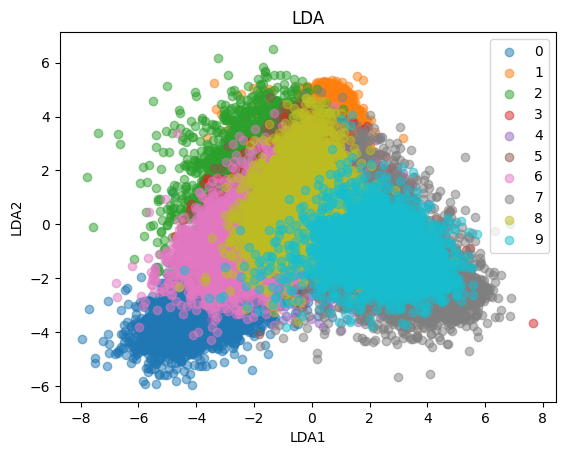

In [20]:
lda = LDA(n_components=2)
x_train_discr = lda.fit_transform(x_train, y_train)
x_test_discr= lda.transform(x_test)
for digit in np.unique(y_train):
    plt.scatter(x_train_discr[y_train == digit, 0],x_train_discr[y_train == digit, 1],label=str(digit),alpha=0.5)
plt.xlabel('LDA1')
plt.ylabel('LDA2')
plt.title('LDA')
plt.legend()
plt.show()


### 5) 
U-MAP works much better when keeping 2 dims. Distance is introduced to each class n just few outliers appear in the wrong classes. It is important to mention that keeping just 2 from 9 dimensions of lda is an overkill.

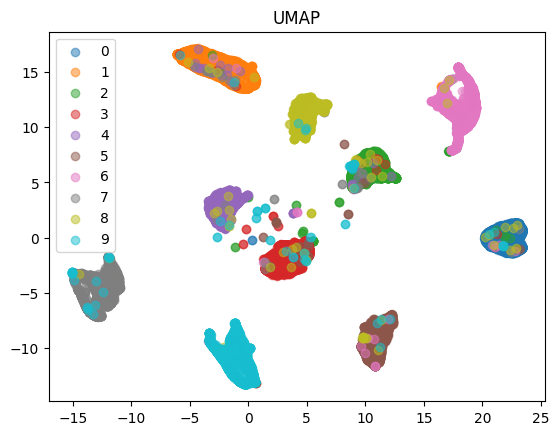

In [21]:
fit = umap.UMAP()
x_train_discr = fit.fit_transform(x_train, y_train)
x_test_discr= fit.transform(x_test)
for digit in np.unique(y_train):
    plt.scatter(x_train_discr[y_train == digit, 0],x_train_discr[y_train == digit, 1],label=str(digit),alpha=0.5)

plt.title('UMAP')
plt.legend()
plt.show()
